In [36]:
# importing all libraries.
import pandas as pd
import statsmodels.api as sm
import math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.formula.api import ols
from sklearn import preprocessing
from scipy import stats

%matplotlib inline
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split,KFold,cross_validate
from sklearn.linear_model import LinearRegression

# Question: how does proximity to water affect price?

#### In this model, we try to understand the relationship between the distance from the coastline and the price for houses in King County.

In [37]:
# dropping extra index column.
df_clean_1 = pd.read_csv('df_clean_1.csv')
df_clean_1 = df_clean_1.drop(['Unnamed: 0'], axis=1)

The first step is some data engineering in order to find the information we need - namely how far away each house is from the coastline. Distance to the coastline was approximated using the distances to the nearest house on the waterfront for each house in the dataset. The process was relatively complicated, and therefore has been kept in another notebook (see *triangulation.ipynb*).

The resulting data was then imported for use in the regression model.

In [38]:
# importing distance data.
df_distance = pd.read_csv('df_distance.csv')
df_distance = df_distance.drop(['Unnamed: 0'], axis=1)
df_distance.head()

,id,distance_to_water
0,7129300520,8.248821
1,6414100192,20.644166
2,5631500400,32.387125
3,2487200875,18.764408
4,1954400510,0.055287


In [39]:
# combining the DFs for use in the model and splitting the target variable.
df_trial = pd.concat([df_clean_1,df_distance], axis=1)
target = df_trial['price']
df_trial.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_living15,sqft_lot15,waterfront_bool,view_cleaned,renovated_bool,age_when_sold,month_of_sale,yr_of_sale,id,distance_to_water
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1340,5650,0.0,0.0,0.0,59.0,10,2014,7129300520,8.248821
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,1690,7639,0.0,0.0,1.0,63.0,12,2014,6414100192,20.644166
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,2720,8062,0.0,0.0,0.0,82.0,2,2015,5631500400,32.387125


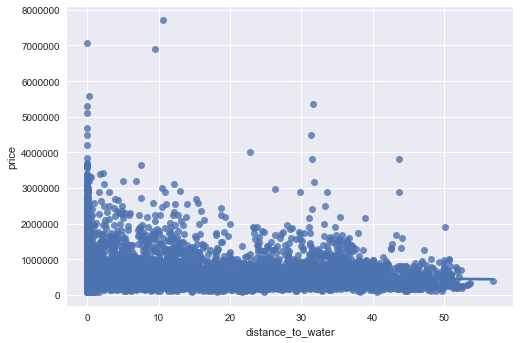

In [40]:
# initial trial to sense-check the correlation.
sns.regplot(df_trial['distance_to_water'], df_trial['price'])
plt.show()

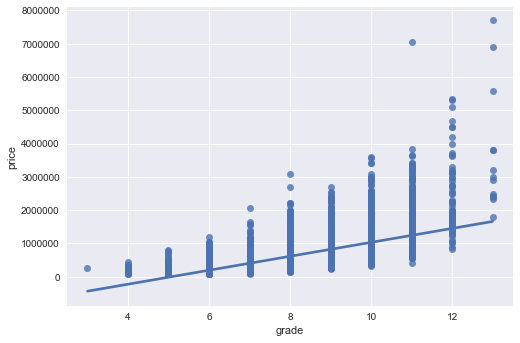

In [41]:
# based on the grouping and the high-price outliers, I imagine that some of the houses may be very large or
# very luxurious. I will consider another variable: grade.
sns.regplot(df_trial['grade'], df_trial['price'])
plt.show()

In [42]:
# grade data is ordinally categorical - so splitting it out into dummy variables.
grade_dummies = pd.get_dummies(df_trial['grade'])
grade_dummies_df = grade_dummies.sort_index()

In [43]:
# merging the dummy data with the main data in a new df.
df_merged = pd.concat([df_trial,grade_dummies_df], axis='columns')
df_merged_2 = df_merged.rename(columns={3: "d3", 4: "d4", 5: "d5",
                                        6: "d6", 7: "d7", 8: "d8",
                                        9: "d9", 10: "d10", 11: "d11",
                                        12: "d12", 13: "d13"})

In [44]:
# dropping the original grade column, and dropping one of the dummy columns to avoid the dummy variable trap.
df_ready = df_merged_2.drop(['grade','d13'],axis='columns')
df_ready.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,d3,d4,d5,d6,d7,d8,d9,d10,d11,d12
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,0,0,0,0,1,0,0,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [45]:
# splitting test and train data.
df_ready, df_test, target, target_test = train_test_split(df_ready,target, test_size=.2, random_state= 42)

In [46]:
# splitting out the chosen features into a smaller df.
df_small = df_ready[['d3','d4','d5','d6','d7','d8','d9','d10','d11','d12','distance_to_water']]

# standardising the two features into z-scores.
df_small['z_distance_to_water'] = stats.zscore(df_small['distance_to_water'])
df_small['z_3'] = stats.zscore(df_small['d3'])
df_small['z_4'] = stats.zscore(df_small['d4'])
df_small['z_5'] = stats.zscore(df_small['d5'])
df_small['z_6'] = stats.zscore(df_small['d6'])
df_small['z_7'] = stats.zscore(df_small['d7'])
df_small['z_8'] = stats.zscore(df_small['d8'])
df_small['z_9'] = stats.zscore(df_small['d9'])
df_small['z_10'] = stats.zscore(df_small['d10'])
df_small['z_11'] = stats.zscore(df_small['d11'])
df_small['z_12'] = stats.zscore(df_small['d12'])

# splitting into standardised and unstandardised dfs.
df_unstandardised = df_small[['d3','d4','d5','d6','d7','d8','d9','d10','d11','d12','distance_to_water']]
df_standardised = df_small[['z_3','z_4','z_5','z_6','z_7','z_8','z_9','z_10','z_11','z_12','z_distance_to_water']]

z_target = stats.zscore(target)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [47]:
# running the model with standardised data.
X_standardised = sm.add_constant(df_standardised)
model_standardised = sm.OLS(target,X_standardised)
results_standardised = model_standardised.fit()

results_standardised.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     1695.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:25:15   Log-Likelihood:            -2.3761e+05
No. Observations:               17133   AIC:                         4.753e+05
Df Residuals:                   17121   BIC:                         4.753e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                5.394e+05   1950.450    276.548      0.000    5.36e+05    5.43e+05
z_3                 -2.763e+04   2046.050    -13.502      0.000   -3.16e+04   -2.36e+04
z_4                 -1.233e+05   3319.748    -37.130      0.000    -1.3e+05   -1.17e+05
z_5                 -3.819e+05   8652.737    -44.142      0.000   -3.99e+05   -3.65e+05
z_6                 -1.049e+06   2.36e+04    -44.533      0.000    -1.1e+06      -1e+06
z_7                 -1.728e+06   3.98e+04    -43.400      0.000   -1.81e+06   -1.65e+06
z_8                 -1.515e+06   3.64e+04    -41.665      0.000   -1.59e+06   -1.44e+06
z_9                 -1.024e+06   2.65e+04    -38.673      0.000   -1.08e+06   -9.72e+05
z_10                -6.324e+05   1.81e+04    -35.025      0.000   -6.68e+05   -5.97e+05
z_11                -3.235e+05    1.1e+04    -29.451      0.000   -3.45e+05   -3.02e+05
z_12                -1.083e+05   5539.666    -19.543      0.000   -1.19e+05   -9.74e+04
z_distance_to_water -9957.3604   1955.715     -5.091      0.000   -1.38e+04   -6123.959
==============================================================================
Omnibus:                    12685.440   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           708920.122
Skew:                           3.021   Prob(JB):                         0.00
Kurtosis:                      33.928   Cond. No.                         43.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# running the model with the fully standardised data.
X_standardised_all = sm.add_constant(df_standardised)
model_standardised_all = sm.OLS(z_target,X_standardised)
results_standardised_all = model_standardised_all.fit()
results_standardised_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     1695.
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:25:15   Log-Likelihood:                -18000.
No. Observations:               17133   AIC:                         3.602e+04
Df Residuals:                   17121   BIC:                         3.612e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const               -9.107e-18      0.005  -1.72e-15      1.000      -0.010       0.010
z_3                    -0.0749      0.006    -13.502      0.000      -0.086      -0.064
z_4                    -0.3342      0.009    -37.130      0.000      -0.352      -0.317
z_5                    -1.0355      0.023    -44.142      0.000      -1.081      -0.989
z_6                    -2.8449      0.064    -44.533      0.000      -2.970      -2.720
z_7                    -4.6839      0.108    -43.400      0.000      -4.895      -4.472
z_8                    -4.1077      0.099    -41.665      0.000      -4.301      -3.914
z_9                    -2.7767      0.072    -38.673      0.000      -2.917      -2.636
z_10                   -1.7143      0.049    -35.025      0.000      -1.810      -1.618
z_11                   -0.8769      0.030    -29.451      0.000      -0.935      -0.819
z_12                   -0.2935      0.015    -19.543      0.000      -0.323      -0.264
z_distance_to_water    -0.0270      0.005     -5.091      0.000      -0.037      -0.017
==============================================================================
Omnibus:                    12685.440   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           708920.122
Skew:                           3.021   Prob(JB):                         0.00
Kurtosis:                      33.928   Cond. No.                         43.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
# printing summary parameters
print('Parameters:')
print('-----------')
print('Constant:',round(results_standardised_all.params[0],3))
print('Z-grade-3:',round(results_standardised_all.params[1],3))
print('Z-grade-4:',round(results_standardised_all.params[2],3))
print('Z-grade-5:',round(results_standardised_all.params[3],3))
print('Z-grade-6:',round(results_standardised_all.params[4],3))
print('Z-grade-7:',round(results_standardised_all.params[5],3))
print('Z-grade-8:',round(results_standardised_all.params[6],3))
print('Z-grade-9:',round(results_standardised_all.params[7],3))
print('Z-grade-10:',round(results_standardised_all.params[8],3))
print('Z-grade-11:',round(results_standardised_all.params[9],3))
print('Z-grade-12:',round(results_standardised_all.params[10],3))
print('Z-distance to water:',round(results_standardised_all.params[11],3))

Parameters:
-----------
Constant: -0.0
Z-grade-3: -0.075
Z-grade-4: -0.334
Z-grade-5: -1.035
Z-grade-6: -2.845
Z-grade-7: -4.684
Z-grade-8: -4.108
Z-grade-9: -2.777
Z-grade-10: -1.714
Z-grade-11: -0.877
Z-grade-12: -0.293
Z-distance to water: -0.027


In [50]:
# this suggests that, the grade being held equal, the price will drop by 0.09 standard deviations for every
# increase in standard deviation in distance from the coast.

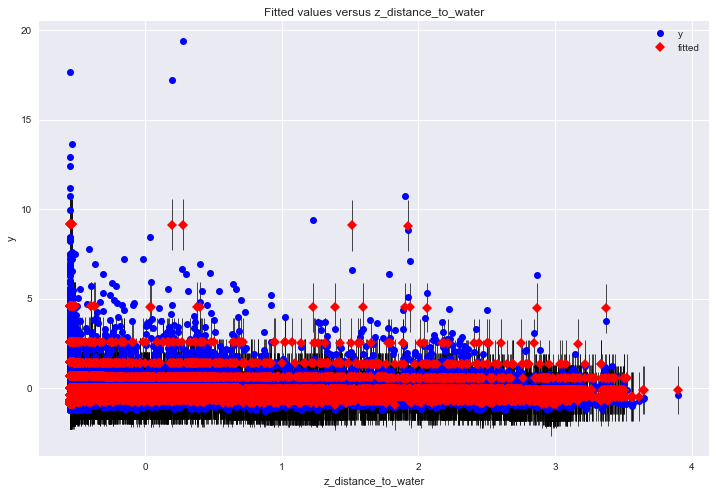

In [51]:
fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(results_standardised_all, "z_distance_to_water", ax=ax)

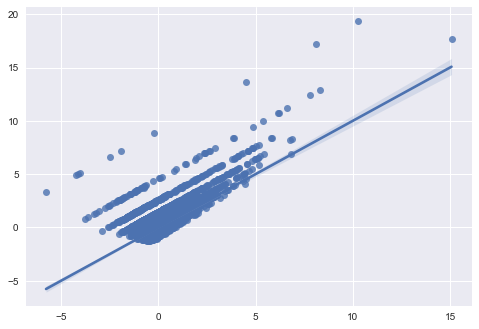

In [52]:
sns.regplot(results_standardised_all.resid, z_target)
plt.show()

In [53]:
# getting the test data ready to run
df_test_small = df_test[['d3','d4','d5','d6','d7','d8','d9','d10','d11','d12','distance_to_water']]

In [54]:
# running the test data
X_test = sm.add_constant(df_test_small)
model_test = sm.OLS(target_test,X_test)
results_test = model_test.fit()

results_test.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     464.8
Date:                Sun, 29 Mar 2020   Prob (F-statistic):               0.00
Time:                        11:25:17   Log-Likelihood:                -59349.
No. Observations:                4284   AIC:                         1.187e+05
Df Residuals:                    4273   BIC:                         1.188e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.064e+06   1.45e+05     21.072      0.000    2.78e+06    3.35e+06
d3                  2.75e-08   1.73e-09     15.904      0.000    2.41e-08    3.09e-08
d4                -2.837e+06    1.7e+05    -16.651      0.000   -3.17e+06    -2.5e+06
d5                -2.829e+06    1.5e+05    -18.844      0.000   -3.12e+06   -2.53e+06
d6                -2.754e+06   1.46e+05    -18.877      0.000   -3.04e+06   -2.47e+06
d7                -2.654e+06   1.45e+05    -18.245      0.000   -2.94e+06   -2.37e+06
d8                -2.509e+06   1.46e+05    -17.243      0.000   -2.79e+06   -2.22e+06
d9                 -2.31e+06   1.46e+05    -15.850      0.000    -2.6e+06   -2.02e+06
d10               -1.966e+06   1.46e+05    -13.441      0.000   -2.25e+06   -1.68e+06
d11               -1.546e+06   1.48e+05    -10.449      0.000   -1.84e+06   -1.26e+06
d12               -8.987e+05   1.58e+05     -5.674      0.000   -1.21e+06   -5.88e+05
distance_to_water  -402.5350    297.451     -1.353      0.176    -985.693     180.623
==============================================================================
Omnibus:                     2738.963   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            66393.615
Skew:                           2.647   Prob(JB):                         0.00
Kurtosis:                      21.545   Cond. No.                     1.12e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.63e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [55]:
# printing summary parameters
print('Parameters:')
print('-----------')
print('Constant:',round(results_test.params[0],3))
print('grade-3:',round(results_test.params[1],3))
print('grade-4:',round(results_test.params[2],3))
print('grade-5:',round(results_test.params[3],3))
print('grade-6:',round(results_test.params[4],3))
print('grade-7:',round(results_test.params[5],3))
print('grade-8:',round(results_test.params[6],3))
print('grade-9:',round(results_test.params[7],3))
print('grade-10:',round(results_test.params[8],3))
print('grade-11:',round(results_test.params[9],3))
print('grade-12:',round(results_test.params[10],3))
print('distance to water:',round(results_test.params[11],3))

Parameters:
-----------
Constant: 3063942.553
grade-3: 0.0
grade-4: -2837417.18
grade-5: -2828643.748
grade-6: -2753719.611
grade-7: -2653857.95
grade-8: -2509208.233
grade-9: -2310483.405
grade-10: -1965932.436
grade-11: -1546182.467
grade-12: -898743.391
distance to water: -402.535


In [56]:
# creating a function to run the model on new data.
def predictor_trial(grade, distance_to_water_in_km):

    const = round(results_test.params[0],3)
    g_3 = round(results_test.params[1],3)
    g_4 = round(results_test.params[2],3)
    g_5 = round(results_test.params[3],3)
    g_6 = round(results_test.params[4],3)
    g_7 = round(results_test.params[5],3)
    g_8 = round(results_test.params[6],3)
    g_9 = round(results_test.params[7],3)
    g_10 = round(results_test.params[8],3)
    g_11 = round(results_test.params[9],3)
    g_12 = round(results_test.params[10],3)
    dist_coef = round(results_test.params[11],3)
    
    grade_list = [g_3,g_4,g_5,g_6,g_7,g_8,g_9,g_10,g_11,g_12]
        
    if grade in range(3,13):
        grade_coef = grade_list[grade-3]
    else:
        return "Grade value not in range"
    
    return print("$",round(const+(grade_coef)+(distance_to_water_in_km*dist_coef),0))

In [57]:
# running predictor function
predictor_trial(7,15)

$ 404047.0


In [58]:
# investigating the difference between waterfront and non-waterfront houses.
waterfront_houses = df_trial.loc[(df_trial['waterfront_bool'] == 1)]
non_waterfront_houses = df_trial.loc[(df_trial['waterfront_bool'] == 0)]

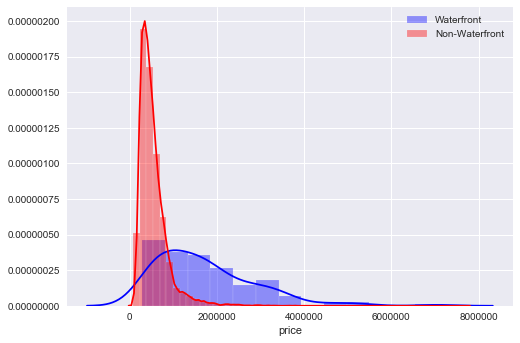

The mean price of a waterfront house is $ 1717215
The mean price of a non-waterfront house is $ 532560


In [59]:
# plotting the difference between waterfront and non-waterfront houses.
sns.distplot(waterfront_houses['price'], color='blue', label='Waterfront')
sns.distplot(non_waterfront_houses['price'], color='red', label='Non-Waterfront')
plt.legend()
plt.show()
print('The mean price of a waterfront house is $',round(waterfront_houses['price'].mean()))
print('The mean price of a non-waterfront house is $',round(non_waterfront_houses['price'].mean()))

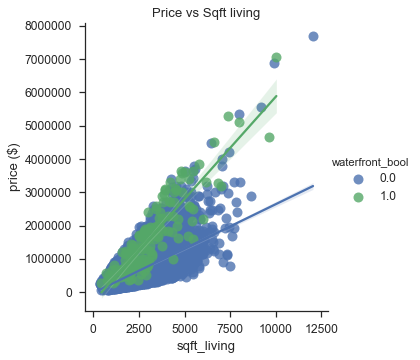

In [60]:
# plotting the difference taking size (square footage) into account.
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
sns.lmplot('sqft_living', 
           'price', 
           data=df_clean_1,
           hue = "waterfront_bool",
           fit_reg=True,
           scatter_kws={"marker": "D",
                        "s": 100}) 


plt.title('Price vs Sqft living')
plt.xlabel('sqft_living')
plt.ylabel('price ($)')
plt.show()